# Collision Avoidance - Live Demo

In this notebook we'll use the model we trained to detect whether the robot is ``free`` or ``blocked`` to enable a collision avoidance behavior on the robot.  

## Load the trained model

We'll assumed that you've already downloaded the ``collision_avoidance.9999999999.h5`` to your Jetbot.  

> Please make sure the file has uploaded fully before calling the next cell

Execute the code below to initialize the TensorFlow model.  

In [1]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
    print('passing')
    pass

passing


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [3]:
import time
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers

Next, load the trained model from the ``collision_avoidance.9999999999.h5`` file that you uploaded

In [4]:
model_path = '/home/jetbot/Notebooks/my_collision_avoidance/collision_avoidance.1577936737.h5'

In [5]:
reloaded = tf.keras.models.load_model(
  model_path, 
  # `custom_objects` tells keras how to load a `hub.KerasLayer`
  custom_objects={'KerasLayer': hub.KerasLayer})

reloaded.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [9]:
IMAGE_RES = 224

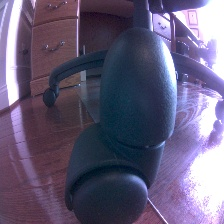

In [10]:
import numpy as np
import PIL.Image as Image

test_image = tf.keras.utils.get_file('image.jpg','file:///home/jetbot/Notebooks/my_collision_avoidance/content/free_blocked/validation/blocked/00ad54cc-2ccd-11ea-ae3b-72b5f773b75d.jpg')
test_image = Image.open(test_image).resize((IMAGE_RES, IMAGE_RES))
test_image 

In [11]:
test_image = np.array(test_image)/255.0
test_image.shape

(224, 224, 3)

In [12]:
result = reloaded.predict(test_image[np.newaxis, ...])
result.shape

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node sequential/keras_layer/StatefulPartitionedCall/StatefulPartitionedCall/StatefulPartitionedCall/predict/MobilenetV2/Conv/Conv2D}}]] [Op:__inference_distributed_function_11992]

Function call stack:
distributed_function


In [ ]:
from tensorflow.keras.preprocessing import image
test_image = image.load_img('/home/jetbot/Notebooks/my_collision_avoidance/content/free_blocked/validation/blocked/00ad54cc-2ccd-11ea-ae3b-72b5f773b75d.jpg', 
                            target_size=(IMAGE_RES,IMAGE_RES))

test_image = image.img_to_array(test_image)
#test_image = np.expand_dims(test_image, axis=0)
test_image = np.array(test_image)/255.0
#test_image = test_image.reshape(IMAGE_RES, IMAGE_RES,3)

In [ ]:
result = reloaded.predict(test_image[np.newaxis, ...])

In [ ]:
print result

In [13]:
model_dir = '/home/jetbot/Notebooks/my_collision_avoidance/collision_avoidance.1577941915'

In [15]:
reload_sm_keras = tf.keras.models.load_model(
  model_dir,
  custom_objects={'KerasLayer': hub.KerasLayer})

reload_sm_keras.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [16]:
result = reload_sm_keras.predict(test_image[np.newaxis, ...])
result.shape

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node sequential/keras_layer/StatefulPartitionedCall/StatefulPartitionedCall/StatefulPartitionedCall/StatefulPartitionedCall/StatefulPartitionedCall/predict/MobilenetV2/Conv/Conv2D}}]] [Op:__inference_distributed_function_55777]

Function call stack:
distributed_function


In [14]:
reloaded_sm = tf.saved_model.load(model_dir)

In [ ]:
reloaded_sm.summary()

Currently, the model weights are located on the CPU memory execute the code below to transfer to the GPU device.

Great! We've now defined our pre-processing function which can convert images from the camera format to the neural network input format.

Now, let's start and display our camera.  We'll also create a slider that will display the probability that the robot is blocked.

In [ ]:
import traitlets
from IPython.display import display
import ipywidgets.widgets as widgets
from jetbot import Camera, bgr8_to_jpeg

camera = Camera.instance(width=224, height=224)
image = widgets.Image(format='jpeg', width=224, height=224)
blocked_slider = widgets.FloatSlider(description='blocked', min=0.0, max=1.0, orientation='vertical')

camera_link = traitlets.dlink((camera, 'value'), (image, 'value'), transform=bgr8_to_jpeg)

display(widgets.HBox([image, blocked_slider]))

We'll also create our robot instance which we'll need to drive the motors.

In [ ]:
from jetbot import Robot

robot = Robot()

Next, we'll create a function that will get called whenever the camera's value changes.  This function will do the following steps

1. Pre-process the camera image
2. Execute the neural network
3. While the neural network output indicates we're blocked, we'll turn left, otherwise we go forward.

In [ ]:
import torch.nn.functional as F
import time

def update(change):
    global blocked_slider, robot
    x = change['new'] 
    x = preprocess(x)
    y = model(x)
    
    # we apply the `softmax` function to normalize the output vector so it sums to 1 (which makes it a probability distribution)
    y = F.softmax(y, dim=1)
    
    prob_blocked = float(y.flatten()[0])
    
    blocked_slider.value = prob_blocked
    
    if prob_blocked < 0.5:
        robot.forward(0.4)
    else:
        robot.left(0.4)
    
    time.sleep(0.001)
        
update({'new': camera.value})  # we call the function once to intialize

Cool! We've created our neural network execution function, but now we need to attach it to the camera for processing. 

We accomplish that with the ``observe`` function.

> WARNING: This code will move the robot!! Please make sure your robot has clearance.  The collision avoidance should work, but the neural
> network is only as good as the data it's trained on!

In [ ]:
camera.observe(update, names='value')  # this attaches the 'update' function to the 'value' traitlet of our camera

Awesome! If your robot is plugged in it should now be generating new commands with each new camera frame.  Perhaps start by placing your robot on the ground and seeing what it does when it reaches an obstacle.

If you want to stop this behavior, you can unattach this callback by executing the code below.

In [ ]:
camera.unobserve(update, names='value')
robot.stop()

Perhaps you want the robot to run without streaming video to the browser.  You can unlink the camera as below.

In [ ]:
camera_link.unlink()  # don't stream to browser (will still run camera)

To continue streaming call the following.

In [ ]:
camera_link.link()  # stream to browser (wont run camera)

### Conclusion

That's it for this live demo!  Hopefully you had some fun and your robot avoided collisions intelligently! 

If your robot wasn't avoiding collisions very well, try to spot where it fails.  The beauty is that we can collect more data for these failure scenarios
and the robot should get even better :)